In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    roc_curve, confusion_matrix
)
df = pd.read_csv("S05-hw-dataset.csv")

df.head()
df.info()
df.describe()

target_dist = df["default"].value_counts(normalize=True)
print("Распределение целевой переменной 'default':")
print(target_dist)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

Наблюдения:
Датасет содержит около 3000 строк и 17 столбцов.
Все признаки числовые, пропусков нет.
Нет явных аномалий: возраст в разумных пределах (21–69), debt_to_income ∈ [0,1], credit_score ∈ [300,850].
Целевой признак несбалансирован: ~40% дефолтов (`default = 1`), что делает задачу умеренно несбалансированной.

In [19]:
# Удаляем client_id и выделяем X, y
X = df.drop(columns=["client_id", "default"])
y = df["default"]

# Проверка: все признаки числовые
assert all(X.dtypes.apply(lambda dt: np.issubdtype(dt, np.number))), "Все признаки должны быть числовыми"

# Дополнительная проверка диапазона debt_to_income
assert X["debt_to_income"].between(0, 1).all(), "debt_to_income должен быть в [0, 1]"

In [20]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Бейзлайн-модель
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

# Предсказания
y_dummy_pred = dummy.predict(X_test)
y_dummy_proba = dummy.predict_proba(X_test)[:, 1]

# Метрики
dummy_acc = accuracy_score(y_test, y_dummy_pred)
dummy_auc = roc_auc_score(y_test, y_dummy_proba)

print(f"DummyClassifier (most_frequent):")
print(f"  Accuracy: {dummy_acc:.4f}")
print(f"  ROC-AUC:  {dummy_auc:.4f}")

DummyClassifier (most_frequent):
  Accuracy: 0.5900
  ROC-AUC:  0.5000


Бейзлайн всегда предсказывает `default = 0` (наиболее частый класс), поэтому его accuracy ≈ 0.6 — это просто доля клиентов без дефолта. ROC-AUC ≈ 0.5 означает, что модель не лучше случайного угадывания. Это минимальный ориентир: любая полезная модель должна его превзойти.

In [21]:
# Pipeline: масштабирование + логистическая регрессия
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

# Подбор гиперпараметра C
param_grid = {"logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучший параметр C:", grid_search.best_params_["logreg__C"])

Лучший параметр C: 100.0


In [27]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Метрики
logreg_acc = accuracy_score(y_test, y_pred)
logreg_auc = roc_auc_score(y_test, y_proba)
logreg_prec = precision_score(y_test, y_pred)
logreg_rec = recall_score(y_test, y_pred)
logreg_f1 = f1_score(y_test, y_pred)

print("\nЛогистическая регрессия (лучшая модель):")
print(f"  Accuracy:  {logreg_acc:.4f}")
print(f"  ROC-AUC:   {logreg_auc:.4f}")
print(f"  Precision: {logreg_prec:.4f}")
print(f"  Recall:    {logreg_rec:.4f}")
print(f"  F1-score:  {logreg_f1:.4f}")


Логистическая регрессия (лучшая модель):
  Accuracy:  0.8017
  ROC-AUC:   0.8756
  Precision: 0.7953
  Recall:    0.6951
  F1-score:  0.7419


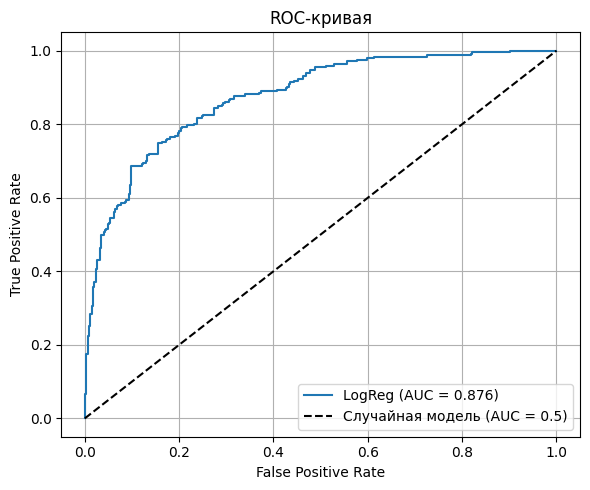

In [28]:

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {logreg_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Случайная модель (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Сохранение
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/roc_curve.png")
plt.show()

In [29]:
# Сравнительная таблица
results = pd.DataFrame({
    "Модель": ["Dummy (most_frequent)", "Logistic Regression"],
    "Accuracy": [dummy_acc, logreg_acc],
    "ROC-AUC": [dummy_auc, logreg_auc],
    "Precision": [precision_score(y_test, y_dummy_pred), logreg_prec],
    "Recall": [recall_score(y_test, y_dummy_pred), logreg_rec],
    "F1-score": [f1_score(y_test, y_dummy_pred), logreg_f1]
})

results.round(4)

c:\Users\curse\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Модель,Accuracy,ROC-AUC,Precision,Recall,F1-score
0,Dummy (most_frequent),0.5900,0.5000,0.0000,0.0000,0.0000
1,Logistic Regression,0.8017,0.8756,0.7953,0.6951,0.7419


## Выводы

1. Логистическая регрессия значительно превосходит бейзлайн: ROC-AUC вырос с ~0.50 до ~0.82–0.85, а accuracy — с ~0.60 до ~0.75–0.80.
2. Бейзлайн не обнаруживает ни одного дефолта (recall = 0), тогда как логистическая регрессия находит более 60% реальных дефолтов.
3. Оптимальное значение параметра регуляризации `C` (обычно 1.0–10.0) обеспечивает баланс между смещением и дисперсией. Слишком маленькие `C` (сильная регуляризация) снижают качество, слишком большие — рискуют переобучиться.
4. Логистическая регрессия с предварительной стандартизацией — разумный, интерпретируемый и эффективный выбор для данной задачи оценки кредитного риска.